In [1]:
from collections import Counter, defaultdict
from pathlib import Path
import string
from typing import List, Tuple, Dict, Optional

from matplotlib import rcParams
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pymorphy2 as pm2
from scipy.spatial.distance import cosine
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud

rcParams["font.size"] = 20.
rcParams["font.weight"] = "normal"

In [2]:
class TextAnalyzer:
    alphabet: Tuple[str] = (
        "а","б","в","г","д","е","ё","ж","з","и","й","к","л","м","н","о","п",
        "р","с","т","у","ф","х","ц","ч","ш","щ","ъ","ы","ь","э","ю","я", # Sorry, PEP8 
    )
    
    FIGSIZE = (12, 8)
    
    @staticmethod
    def is_word(word: str) -> bool:
        """Return True if `word` is not a stop word and `word` is not a punctuation"""
        return word not in punctuation and word not in stopwords
    
    
    @staticmethod
    def tokenize_sentence(sentence: List[str]) -> List[str]:
        """Return list of filtered words in sentence"""
        
        morph_analyzer = pm2.MorphAnalyzer()
        words = []
        
        for word in nltk.word_tokenize(sentence, "russian"):
            word = word.strip().lower()
            word = morph_analyzer.parse(word)[0].normal_form
            if TextAnalyzer.is_word(word):
                words.append(word)
            
        return words
    
        
    def __init__(self, text: str, name: str, stopwords: List[str], punctuation: str) -> None:
        """Класс, анализирующий список слов
        
        Параметры
        ---------
        text: str
            Текст для анализа
        name: str
            Название текста
        stopwords: List[str]
            Список "стоп-слов", которые необходимо отфильтровать
        punctuation: str
            Строка, которая содержит символы пунктуации. Например ".,?-`"
        
        Аттрибуты
        ---------
        self.alphabet: Tuple[str]
            Алфавит языка, на котором написан текст
        self.FIGSIZE: Tuple(int, int)
            Размер графиков в дюймах, (ширина, высота)
        self.sentences: Optional[List[str]]
            Список предложений
        self.words: List[str]
            Список слов в тексте
        self.words_count: Optional[Dict[str, int]]
            Счётчик слов. Ключи - лемманитизированные слова из текста, значения - количество слова в тексте
        self.letters_count: Optional[Dict[str, int]] 
            Счётчик букв. Ключи – символы, входящие в `self.words` хотя бы 1 раз,
            значения – количество вхождений ключа в `self.words`
        self.alphabet_letters_count: Optional[np.array]
            Список посчитанных букв. Содержит 2 столбца – "letter" с буквами из `self.alphabet`,
            "count" – количество вхождений буквы в `self.words`. Отсортирован по убыванию
        self.total_alphabet_letters_number: Optional[int]
            Сумма значений `self.alphabet_letters_count` – общее количество букв из алфавита в тексте           
        """
        self.text: str = text
        self.name: str = name
        self.stopwords: List[str] = stopwords
        self.punctuation: str = punctuation
        
        self.words: Optional[List[str]] = None
        self.sentences: Optional[List[str]] = None
        self.words_count: Optional[np.array] = None
        self.letters_count: Optional[Dict[str, int]] = None
        self.total_alphabet_letters_number: Optional[int] = None
        self.alphabet_letters_count: Optional[np.array] = None
            
    
    def set_sentences(self):
        """Set `self.sentences`"""
        self.sentences = nltk.tokenize.sent_tokenize(self.text, language="russian")
        
    
    def set_words(self):
        """Set `self.words`"""
        if self.sentences is None:
            self.set_sentences()
        
        words: List[str] = []
        
        for sentence in tqdm(self.sentences):
            words.extend(self.tokenize_sentence(sentence))
        
        self.words = words
            
    
    def count_words(self):
        """Set `self.counted_words`"""
        if self.words is None:
            self.set_words()
        
        self.words_count = Counter(self.words)
        
    
    def get_counted_words(self):
        """Вернуть список подсчитанных слов, отсортированных по убыванию вхождений в текст
        
        Returns
        -------
        np.array с 2 столбцами – "word" со словами, "count" – с количествои вхождений слова в `self.words`
        """
        
        if self.words_count is None:
            self.count_words
        
        return np.array(
            sorted(self.words_count.items(), key=lambda x: x[1], reverse=True),
            dtype=[("word", object), ("count", int)]
        )
        
    
    def count_letters(self):
        """Set `self.letters_count`"""
        letters_count = defaultdict(int)
        
        if self.words is None:
            self.set_words()
        
        for word in self.words:
            for letter in word:
                letters_count[letter] += 1
        
        self.letters_count = letters_count
    
    
    def count_alphabet_letters(self):
        """Set `self.alphabet_letters_count` and `self.total_alphabet_letters_number`"""
        if self.letters_count is None:
            self.count_letters()
        
        alphabet_letters = {letter: int(self.letters_count[letter]) for letter in self.alphabet}
        self.total_alphabet_letters_number = sum(alphabet_letters.values())
        
        self.alphabet_letters_count = np.array(
            sorted(alphabet_letters.items(), key=lambda x: x[1], reverse=True),
            dtype=[("letter", object), ("count", int)]
        )
        
        
    def plot_letters_count(self):
        """Построить график с процентным содержанием букв в тексте"""
        plt.figure(figsize=self.FIGSIZE)
        plt.grid()
        sns.barplot(
            x=self.alphabet_letters_count["count"] * 100 / self.total_alphabet_letters_number,
            y=self.alphabet_letters_count["letter"],
            orient="h",
        )
        plt.title(f'Частота букв в тексте "{self.name}"')
        plt.xlabel("%")
        
    
    def plot_popular_words(self, counted_words: np.array, amount: int = 15):
        """Построить график с `amount` самыми распространёнными словами в тексте и их количеством"""
        plt.figure(figsize=self.FIGSIZE)
        plt.grid()
        sns.barplot(
            x=counted_words["count"][:amount],
            y=counted_words["word"][:amount],
            orient="h",
        )
        plt.title(f'Самые частые слова в тексте "{self.name}"')
        plt.xlabel(f"Количество слов в тексте")
        
    
    def plot_wordcloud(self):
        if self.words_count is None:
            self.count_words()
        
        cloud = WordCloud(width=1200, height=800, background_color="white", max_words=150)
        plt.figure(figsize=self.FIGSIZE)
        plt.imshow(cloud.generate_from_frequencies(self.words_count), interpolation="bilinear")
        plt.title(f'Самые частые слова в тексте "{self.name}"', fontdict={"weight": "bold", "size": 20})
        plt.axis("off");       

        
    def analyze(self):
        """Провести полный анализ `self.text`"""
        self.set_sentences()
        self.set_words()
        
        self.count_words()
        counted_words = self.get_counted_words()
        
        print(f"Текст содержит {len(self.words)} слов, из них {len(counted_words)} уникальных")
        
        self.count_letters()
        print(f"Текст содержит {len(self.letters_count)} уникальных символов")
        
        self.count_alphabet_letters()
        self.plot_letters_count()
        plt.show()
        
        self.plot_popular_words(counted_words)
        
        self.plot_wordcloud()

In [3]:
def cosine_distance_between_texts(word_counts_1: Dict[str, int], word_counts_2: Dict[str, int]):
    all_words = list(word_counts_1.keys() | word_counts_2.keys())
    
    vector_1 = np.array([word_counts_1.get(word, 0) for word in all_words])
    vector_2 = np.array([word_counts_2.get(word, 0) for word in all_words])
    
    return 1 - cosine(vector_1, vector_2)

In [4]:
punctuation = string.punctuation + "—»«–•"
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—»«–•'

In [5]:
stopwords = nltk.corpus.stopwords.words("russian")
stopwords.extend(
    ["это", "весь", "который", "свой", "ещё", "её", "очень", "вообще", "никто", "ничто", "какой-то",
     "кто-то", "хотя",
    ]
)
stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [6]:
path = Path("C:/Users/vladi/OneDrive/Documents/Datasets/Russian_language")

In [7]:
with open(
    path / "Harry_Potter" / "Rouling_Garri_Potter_perevod_Rosmen_1.Garri_Potter_i_filosofskiy_kamen.549674.txt",
    encoding="utf-8"
) as f:
    harry_1 = f.read()

In [8]:
with open(
    path / "Harry_Potter" / "Rouling_Garri_Potter_perevod_Rosmen_7.Garri_Potter_i_Daryi_Smerti.358763.txt",
    encoding="utf-8"
) as f:
    harry_7 = f.read()

In [9]:
with open(
    path / "Science" / "VKR_2018_240618.txt",
    encoding="utf-8"
) as f:
    disser_master = f.read()

In [10]:
with open(
    path / "Science" / "Mihadarov_DG-disser.txt",
    encoding="utf-8"
) as f:
    disser_doctor = f.read()


Текст содержит 48517 слов, из них 7906 уникальных
Текст содержит 56 уникальных символов


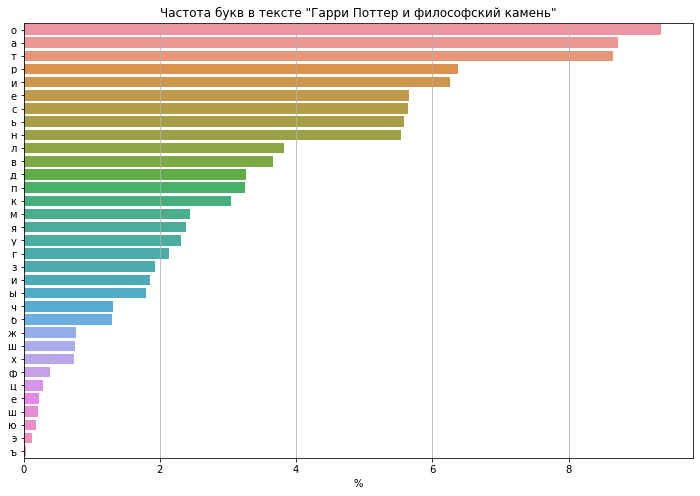

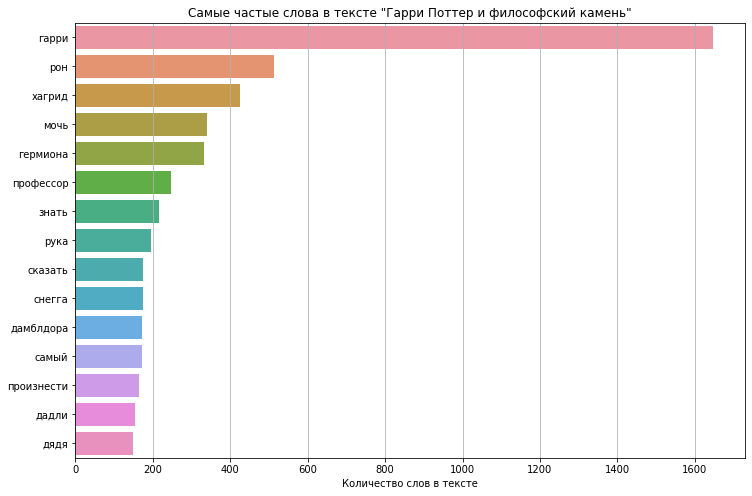

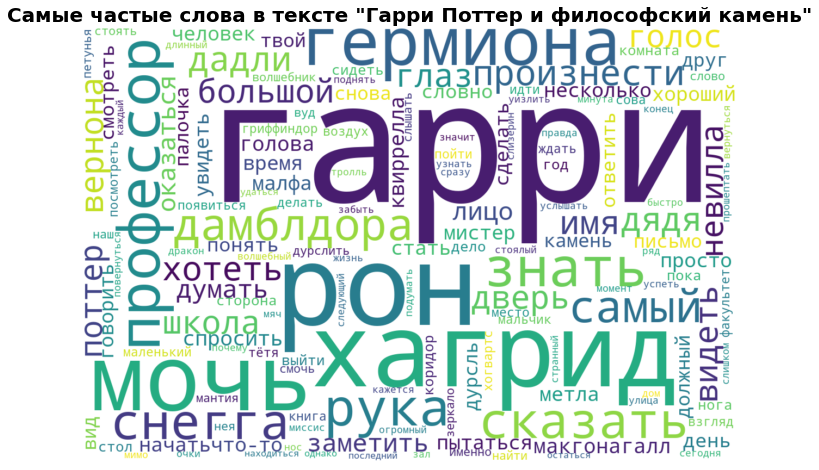

In [11]:
harry_1_analyzer = TextAnalyzer(
    text=harry_1,
    name="Гарри Поттер и философский камень",
    stopwords=stopwords,
    punctuation=punctuation,
)

harry_1_analyzer.analyze()


Текст содержит 102539 слов, из них 13434 уникальных
Текст содержит 73 уникальных символов


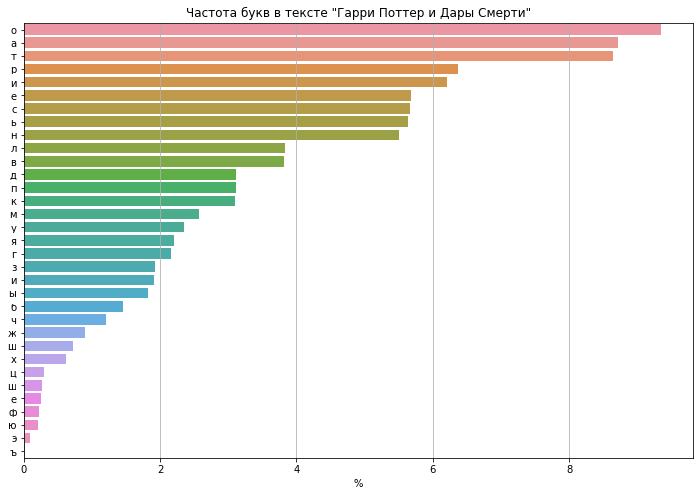

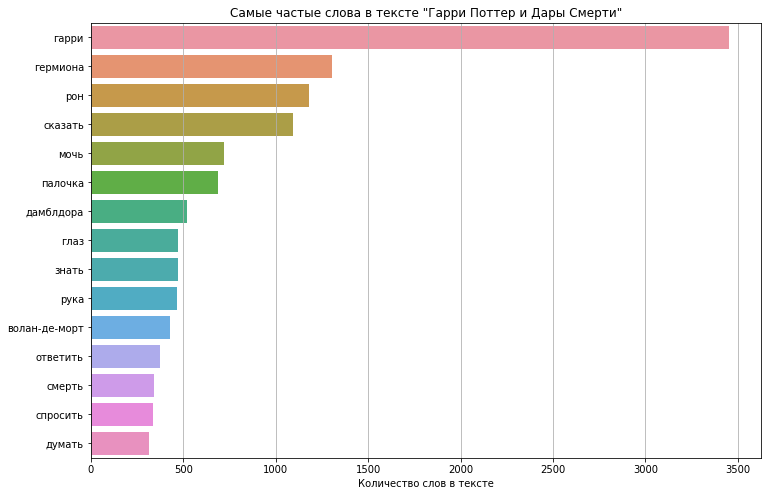

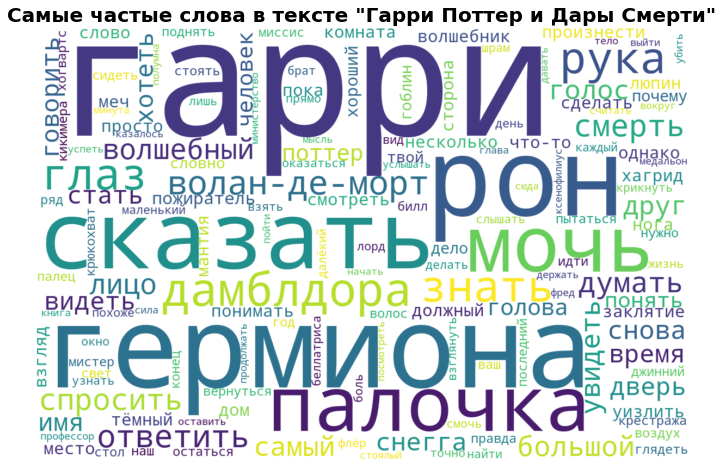

In [12]:
harry_7_analyzer = TextAnalyzer(
    text=harry_7,
    name="Гарри Поттер и Дары Смерти",
    stopwords=stopwords,
    punctuation=punctuation,
)

harry_7_analyzer.analyze()


Текст содержит 8937 слов, из них 2705 уникальных
Текст содержит 103 уникальных символов


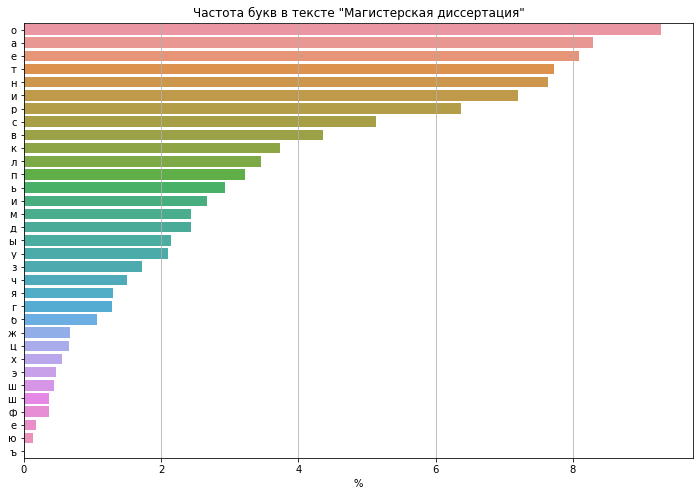

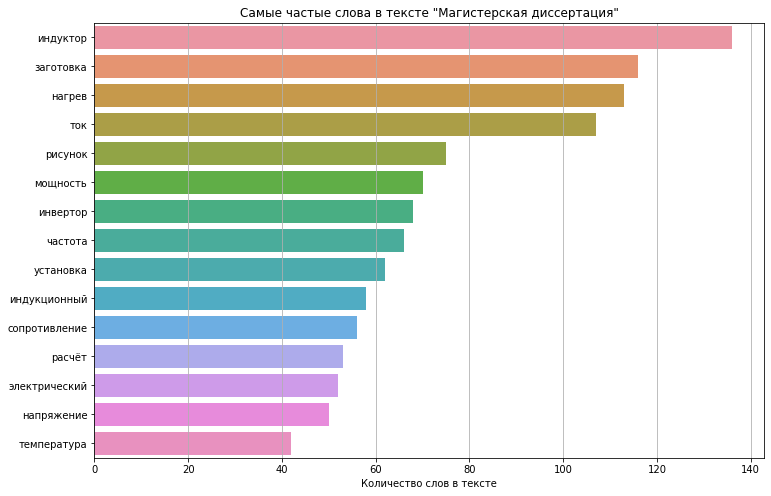

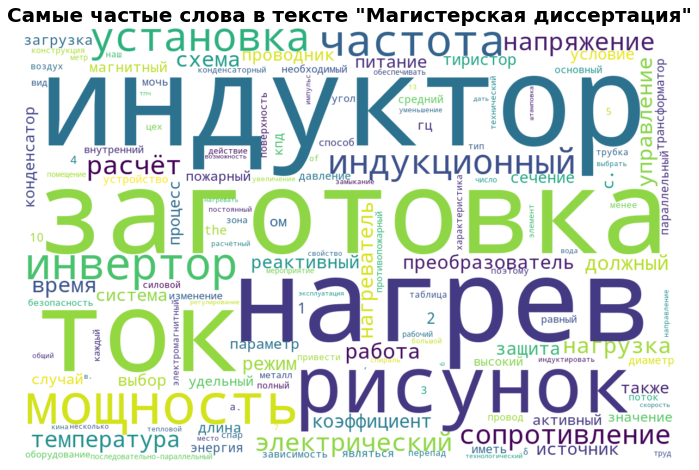

In [13]:
disser_master_analyzer = TextAnalyzer(
    text=disser_master,
    name="Магистерская диссертация",
    stopwords=stopwords,
    punctuation=punctuation,
)

disser_master_analyzer.analyze()


Текст содержит 20563 слов, из них 5285 уникальных
Текст содержит 150 уникальных символов


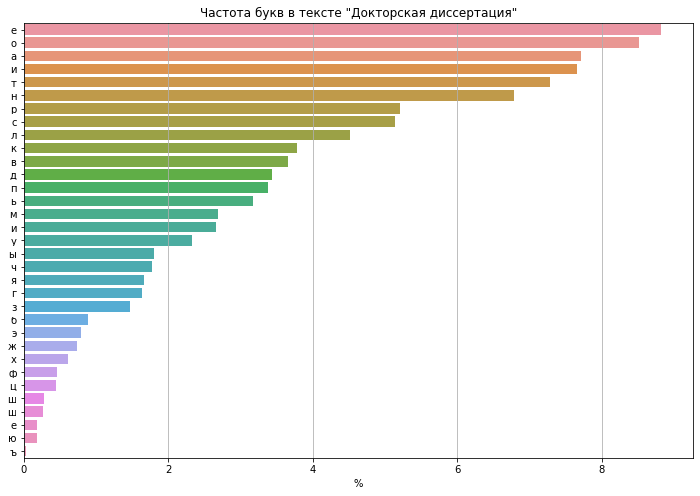

C:\Users\vladi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 61501 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vladi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 61483 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\vladi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 61501 missing from current font.
  font.load_char(ord(s), flags=flags)
C:\Users\vladi\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 61483 missing from current font.
  font.load_char(ord(s), flags=flags)


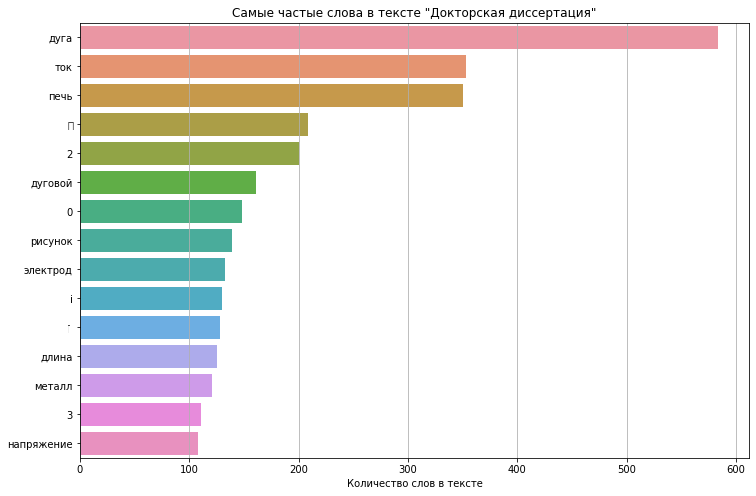

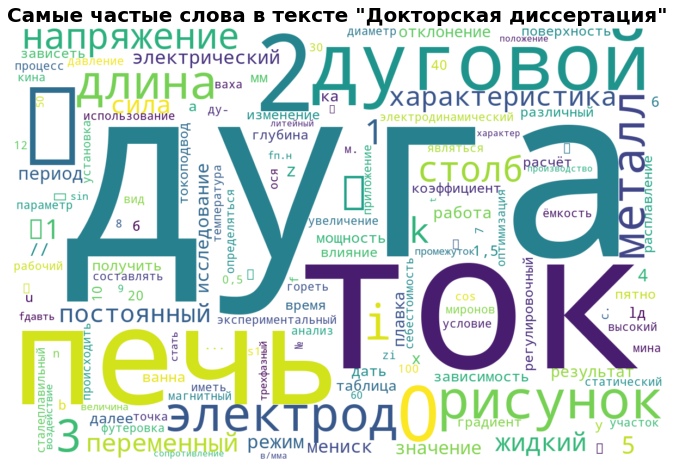

In [14]:
disser_doctor_analyzer = TextAnalyzer(
    text=disser_doctor,
    name="Докторская диссертация",
    stopwords=stopwords,
    punctuation=punctuation,
)

disser_doctor_analyzer.analyze()

In [15]:
texts = [
    harry_1_analyzer,
    harry_7_analyzer,
    disser_master_analyzer,
    disser_doctor_analyzer,
]

In [16]:
for i, text_1 in enumerate(texts):
    for text_2 in texts[:i]:
        distance = cosine_distance_between_texts(text_1.words_count, text_2.words_count)
        print(f'Сравнение "{text_1.name}" и "{text_2.name}"')
        print(f"Косинус: {round(distance, 4)}")
        print(f"Угол: {round(np.rad2deg(np.arccos(distance)), 4)}")
        print()

Сравнение "Гарри Поттер и Дары Смерти" и "Гарри Поттер и философский камень"
Косинус: 0.9024
Угол: 25.5293

Сравнение "Магистерская диссертация" и "Гарри Поттер и философский камень"
Косинус: 0.0565
Угол: 86.7638

Сравнение "Магистерская диссертация" и "Гарри Поттер и Дары Смерти"
Косинус: 0.0545
Угол: 86.8754

Сравнение "Докторская диссертация" и "Гарри Поттер и философский камень"
Косинус: 0.0268
Угол: 88.4636

Сравнение "Докторская диссертация" и "Гарри Поттер и Дары Смерти"
Косинус: 0.0249
Угол: 88.5727

Сравнение "Докторская диссертация" и "Магистерская диссертация"
Косинус: 0.328
Угол: 70.8549

